In [20]:
import glob, os
import fnmatch
import sys
import astropy
import json
import parsnip
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#read from .json file

for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".json"):
        f = open('T202103221404394p014626/'+file)
        data = json.load(f)
        id = data["ObjectID"]
        ra = data['RA-OBJECT']
        dec = data['DEC-OBJECT']
        print (id, ra, dec)

T202103221404394p014626 211.16428283 1.77410113


In [3]:
#read from pdf file

from tika import parser
for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".pdf"):
        pdf = parser.from_file('T202103221404394p014626/'+file)
        text = pdf['content']

In [4]:
rs = ""
for i in range(len(text)):
    if text[i].startswith("T"):
        for j in range(i+36, i+43):
            rs += text[j]
        break
rs = float(rs)
print (rs)

0.22975


In [5]:
#construct a metadata table

from astropy.table import QTable, Table, Column
import numpy as np
metaTable = Table(names=('object_id', 'ra', 'dec', 'type', 'redshift'), dtype=('S2', 'i', 'i', 'S', 'f'))
metaTable.add_row((id, ra, dec, 'Unknown', rs))
print (metaTable)

       object_id         ra dec   type  redshift
----------------------- --- --- ------- --------
T202103221404394p014626 211   1 Unknown  0.22975


In [6]:
#read from .csv file

import csv
import lcdata

lightcurveTable = Table(names=('time(mjd)', 'flux', 'fluxerr', 'band'), dtype=('f', 'f', 'f', 'S'))

for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".csv"):
        csvFile = open('T202103221404394p014626/'+file)
        reader = csv.DictReader(csvFile)
        for row in reader:
            if row['alert'] == 'True':
                time = row['mjd']
                mag = float(row['mag'])
                magerr = float(row['magerr'])
                flux = 10**((22.5-mag)/2.5)
                fluxerr = fluxerr = flux * np.log(10) / 2.5 * magerr
                band = 'lsst' + row['filter']
                lightcurveTable.add_row((time, flux, fluxerr, band))
print (lightcurveTable)

time(mjd)    flux      fluxerr    band
--------- ---------- ----------- -----
 59295.27  2.8618915 0.090408474 lsstg
59295.273   2.875543  0.07861171 lsstr
59295.273  1.9632537  0.16095826 lsstz
59297.227  2.6797485 0.115832634 lsstg
59297.227  2.3984513  0.08548449 lsstr
 59297.23  1.6680049  0.17767365 lsstz
59301.188  3.3626912  0.31039804 lsstr
59301.188  2.3671358   0.2699927 lsstz
59307.336  3.0541835  0.27327675 lsstg
 59310.19   2.031543  0.09946068 lsstg
      ...        ...         ...   ...
 59319.17  1.3874642 0.070573896 lsstg
59319.176  1.9609144  0.07359017 lsstr
59319.176  1.4081056  0.16771111 lsstz
59319.305  1.3832716   0.0759118 lsstg
59322.176  1.5523274  0.07836565 lsstr
59322.176  1.3023627  0.16841514 lsstz
  59322.3  1.1492501  0.09278198 lsstg
 59340.15  1.1042311 0.094568364 lsstr
59343.152 0.98615205   0.1357914 lsstr
59346.156  1.1942683  0.11313347 lsstr
59352.082 0.78507364 0.084839925 lsstr
Length = 30 rows


In [7]:
#combine the two tables into lcdata

light_curve = Table({
     'time': list(lightcurveTable['time(mjd)']),
     'flux': list(lightcurveTable['flux']),
     'fluxerr': list(lightcurveTable['fluxerr']),
     'band': list(lightcurveTable['band']),})

print(light_curve, '\n')

light_curve.meta = {
    'object_id': id,
    'ra': ra,
    'dec': dec,
    'type': "Unknown",
    'redshift': rs}

print(light_curve.meta)

   time      flux      fluxerr    band
--------- ---------- ----------- -----
 59295.27  2.8618915 0.090408474 lsstg
59295.273   2.875543  0.07861171 lsstr
59295.273  1.9632537  0.16095826 lsstz
59297.227  2.6797485 0.115832634 lsstg
59297.227  2.3984513  0.08548449 lsstr
 59297.23  1.6680049  0.17767365 lsstz
59301.188  3.3626912  0.31039804 lsstr
59301.188  2.3671358   0.2699927 lsstz
59307.336  3.0541835  0.27327675 lsstg
 59310.19   2.031543  0.09946068 lsstg
      ...        ...         ...   ...
 59319.17  1.3874642 0.070573896 lsstg
59319.176  1.9609144  0.07359017 lsstr
59319.176  1.4081056  0.16771111 lsstz
59319.305  1.3832716   0.0759118 lsstg
59322.176  1.5523274  0.07836565 lsstr
59322.176  1.3023627  0.16841514 lsstz
  59322.3  1.1492501  0.09278198 lsstg
 59340.15  1.1042311 0.094568364 lsstr
59343.152 0.98615205   0.1357914 lsstr
59346.156  1.1942683  0.11313347 lsstr
59352.082 0.78507364 0.084839925 lsstr
Length = 30 rows 

{'object_id': 'T202103221404394p014626', 'ra'

In [9]:
#create a dataset with the light curve(s)

dataset = lcdata.from_light_curves([light_curve])
print(dataset.meta)

       object_id             ra         dec       type  redshift
----------------------- ------------ ---------- ------- --------
T202103221404394p014626 211.16428283 1.77410113 Unknown  0.22975


In [10]:
print (dataset.light_curves)

[<Table length=30>
      time         flux      fluxerr    band
    float64      float32     float32   bytes5
 -------------- ---------- ----------- ------
 59295.26953125  2.8618915 0.090408474  lsstg
  59295.2734375   2.875543  0.07861171  lsstr
  59295.2734375  1.9632537  0.16095826  lsstz
  59297.2265625  2.6797485 0.115832634  lsstg
  59297.2265625  2.3984513  0.08548449  lsstr
 59297.23046875  1.6680049  0.17767365  lsstz
     59301.1875  3.3626912  0.31039804  lsstr
     59301.1875  2.3671358   0.2699927  lsstz
  59307.3359375  3.0541835  0.27327675  lsstg
 59310.19140625   2.031543  0.09946068  lsstg
            ...        ...         ...    ...
 59319.17578125  1.9609144  0.07359017  lsstr
 59319.17578125  1.4081056  0.16771111  lsstz
  59319.3046875  1.3832716   0.0759118  lsstg
 59322.17578125  1.5523274  0.07836565  lsstr
 59322.17578125  1.3023627  0.16841514  lsstz
 59322.30078125  1.1492501  0.09278198  lsstg
  59340.1484375  1.1042311 0.094568364  lsstr
 59343.15234375 

In [11]:
print(dataset.meta)

       object_id             ra         dec       type  redshift
----------------------- ------------ ---------- ------- --------
T202103221404394p014626 211.16428283 1.77410113 Unknown  0.22975


In [12]:
#save the dataset into .h5 file and read from that file (to test if we still get the same error)

#dataset = lcdata.from_light_curves([light_curve])
#dataset.write_hdf5('./dataset.h5')

#dataset = parsnip.load_dataset('./dataset.h5')

In [13]:
#make prediction with the built-in plasticc model

model = parsnip.load_model('plasticc')
model.predict(light_curve)

E:\Apps\Anaconda3\lib\site-packages\parsnip\parsnip.py:289: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  self.band_interpolate_weights = torch.FloatTensor(band_weights).to(self.device)


{'object_id': 'T202103221404394p014626',
 'ra': 211.16428283,
 'dec': 1.77410113,
 'type': 'Unknown',
 'redshift': 0.22975,
 'parsnip_reference_time': 59310.20035515625,
 'parsnip_scale': 3.3626912,
 'reference_time': 59305.59027539093,
 'reference_time_error': 0.29216895,
 'color': -0.08193455,
 'color_error': 0.013448181,
 'amplitude': 0.023162585,
 'amplitude_error': 0.00022470979,
 's1': -0.05685082,
 's1_error': 0.055308733,
 's2': 0.62492305,
 's2_error': 0.17905389,
 's3': 1.8444418,
 's3_error': 0.36161977,
 'total_s2n': 111.19419,
 'count': 30,
 'count_s2n_3': 30,
 'count_s2n_5': 30,
 'count_s2n_3_pre': 0,
 'count_s2n_3_rise': 8,
 'count_s2n_3_fall': 22,
 'count_s2n_3_post': 0,
 'model_chisq': 223.48491,
 'model_dof': 24,
 'luminosity': -11.276095292694471,
 'luminosity_error': 0.010533493}

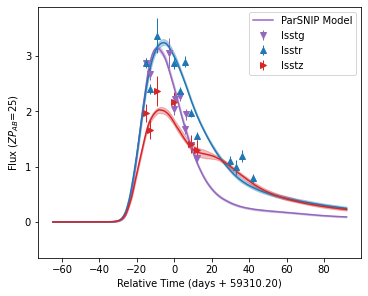

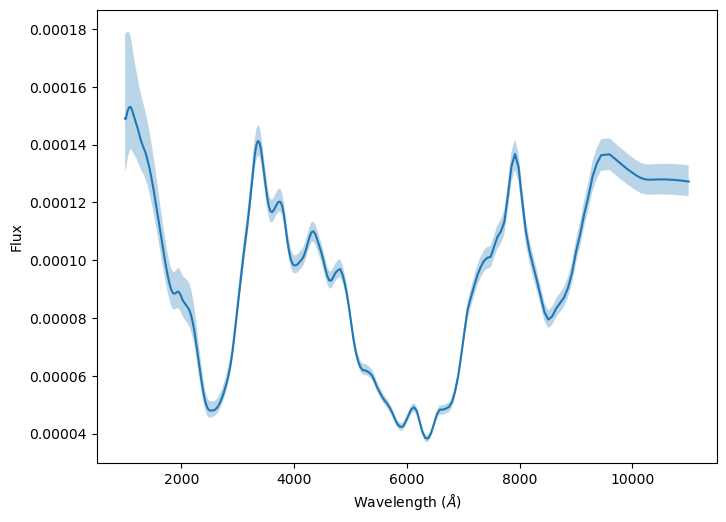

In [15]:
#make plots with the model

parsnip.plot_light_curve(light_curve, model)
parsnip.plot_spectrum(light_curve, model, time=53000.)

In [17]:
#train classifier

predictions_plasticc_train = Table.read('parsnip_predictions/parsnip_predictions_plasticc_train_aug_100.h5')
predictions_plasticc_test = Table.read('parsnip_predictions/parsnip_predictions_plasticc_test.h5')
classifier_plasticc = parsnip.Classifier()
classifications_plasticc_train = classifier_plasticc.train(predictions_plasticc_train)

Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
[100]	valid_0's multi_logloss: 0.524034
[100]	valid_0's multi_logloss: 0.525304
[100]	valid_0's multi_logloss: 0.544961
[100]	valid_0's multi_logloss: 0.564758
[100]	valid_0's multi_logloss: 0.462797
[100]	valid_0's multi_logloss: 0.527013
[100]	valid_0's multi_logloss: 0.55661
[100]	valid_0's multi_logloss: 0.487204
[100]	valid_0's multi_logloss: 0.499258
[100]	valid_0's multi_logloss: 0.544764


In [18]:
classifications_plasticc_test = classifier_plasticc.classify(predictions_plasticc_test)

Macro averaged completeness (Villar et al. 2020): 0.8130
Fraction correct: 0.8007


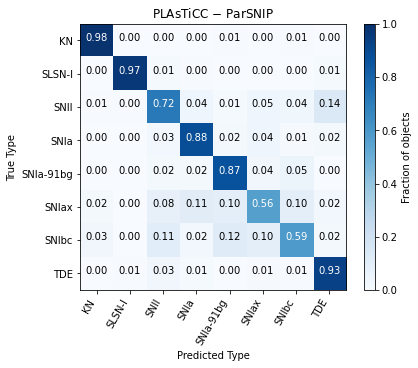

In [23]:
parsnip.plot_confusion_matrix(predictions_plasticc_test, 
                              classifications_plasticc_test, 
                              figsize=(6, 5), title='PLAsTiCC $-$ ParSNIP')
plt.savefig('plasticc_parsnip_confusion_matrix.pdf')

In [29]:
dataset.write_hdf5('./dataset_plasticc.h5')
predictions_plasticc_object = Table.read('dataset_plasticc.h5')

In [34]:
classifier_plasticc.classify(dataset)

KeyError: 'color'